In [1]:
!rm -r DD-GAN-AE
!git clone https://github.com/acse-zrw20/DD-GAN-AE
!pip install ./DD-GAN-AE/
!pip install wandb

rm: cannot remove 'DD-GAN-AE': No such file or directory
Cloning into 'DD-GAN-AE'...
remote: Enumerating objects: 1523, done.
remote: Counting objects: 100% (468/468), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 1523 (delta 323), reused 275 (delta 139), pack-reused 1055
Receiving objects: 100% (1523/1523), 50.10 MiB | 30.63 MiB/s, done.
Resolving deltas: 100% (952/952), done.
Processing ./DD-GAN-AE
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for DD-GAN-AE: filename=DD_GAN_AE-1.0-py3-none-any.whl size=230465 sha256=9fb81c2846f3d71fc60a87837dc7b93664fa4fc3aa709714b3c59f0acffc3450
  Stored in director

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predictive models on slug flow (SF) dataset

Example notebook that displays the functionality of the built package for predicting SF and reproduces the results from the report. Note that this notebook assumes that you already have latent variables or want to use the latent variables from the repo. If not, please see the basic_usage_sf notebook for generating latent variables. 

In [3]:
# All of the necessary external package imports
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import random
from scipy.fft import fft, fftfreq
import six

# Built package imports
from ddganAE.utils import calc_pod
from ddganAE.models import (AAE, AAE_combined_loss, CAE, SVDAE, 
                            Predictive_adversarial, Predictive)
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *

In [4]:
# Setting seeds for reproduceability
seed = 42
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

## Predictive AAE

### Training the predictive AAE

In [5]:
# Data preprocessing and loading
latent_vars = np.load("/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy")
# Also loading the accompanying compressive decoder
compressive_decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_model_different-sweep-1/decoder")

train_data = np.moveaxis(latent_vars.reshape(800, 10, 10),
                                    0, 2)

# Scaling the latent variables
scaler = MinMaxScaler((-1, 1))
train_data = scaler.fit_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

In [ ]:
val_data = train_data[:, :, 600:700]
train_data = np.concatenate((train_data[:, :, :600], train_data[:, :, 700:]), axis=2)

In [ ]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.98, beta_2=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Training, I recommend doing this on the HPC, the scripts to do that are in
# the HPC folder of this repo. To continue without training just follow the next
# cells as the models are loaded in anyway.

encoder = build_slimmer_dense_encoder(
    100,
    initializer,
    info=False,
    act="relu",
    dropout=0.3
)
decoder = build_slimmer_dense_decoder(
    10,
    100,
    initializer,
    info=False,
    act="relu",
    dropout=0.3,
    final_act="tanh"
)
discriminator = build_custom_discriminator(
    100, initializer, info=False
)

pred_adv = Predictive_adversarial(encoder, decoder, discriminator, 
                                  optimizer)
pred_adv.compile(10, increment=False)
pred_adv.train(
    train_data,
    2000,
    interval=6,
    batch_size=32,
    val_data=val_data,
    wandb_log=False,
    noise_std=0.01,
    n_discriminator=1,
    n_gradient_ascent=15
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
pred_adv.save("model_paae")

INFO:tensorflow:Assets written to: model_paae/encoder/assets
INFO:tensorflow:Assets written to: model_paae/decoder/assets
INFO:tensorflow:Assets written to: model_paae/discriminator/assets


In [ ]:
# Uncomment the below to load a previously trained model
# pred_adv = Predictive_adversarial.from_save("/content/drive/MyDrive/Colab Notebooks/model_paae", optimizer)
# pred_adv.compile(10, increment=False)
# pred_adv.interval = 6

Generate a prediction on the validation part of the dataset

In [ ]:
# Generate a prediction on the val dataset

# Create boundaries and initial values to predict the same grid as the initial
# grid
boundaries = np.zeros((2, 10, 100))
boundaries[0] = val_data[2, :, 0:]
boundaries[1] = val_data[9, :, 0:]

init_values = np.zeros((6, 10))
init_values[:] = np.repeat(val_data[3:9, :, 0], 1, axis=0)

In [ ]:
steps_to_predict = 16 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, 
                                    iters=4, sor=1, pre_interval=False)


In [ ]:
# do the inverse transforms
predicted_latent = scaler.inverse_transform(
  predicted_latent.reshape(-1, 1)).reshape(predicted_latent.shape)

true_latent = scaler.inverse_transform(
  val_data.reshape(-1, 1)).reshape(val_data.shape)

# Adding the subdomain 0 back in to go back to 10 subdomains
predicted_latent = np.concatenate((true_latent[0:2, :, :133*6:6], predicted_latent))[:, :, :steps_to_predict]

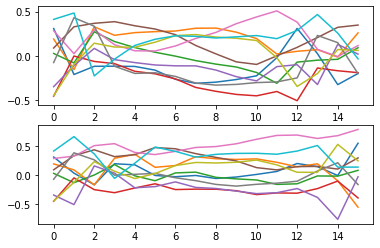

In [ ]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(predicted_latent[4, :, :steps_to_predict].T)
true_latent_interval = true_latent[4, :, :steps_to_predict*6:6]
ax[1].plot(true_latent_interval.T)

In [ ]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent, 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)

In [ ]:
# Loading in the original dataset for comparison
grids = np.load("/content/drive/MyDrive/Colab Notebooks/data/processed/sf_snapshots_800timesteps_notrand.npy")

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

grids = grids[6000:6960] # Only select validation part of dataset

In [ ]:
# Calculate MSE loss
# Reshaping
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
predicted_grids_reshaped = predicted_grids.numpy().reshape((int(predicted_grids.shape[0]/10), 10, predicted_grids.shape[1], predicted_grids.shape[2], predicted_grids.shape[3], predicted_grids.shape[4]))

print("MSE loss of the prediction on unseen validation dataset: ", np.mean(tf.keras.losses.MSE(grids_reshaped[:steps_to_predict*6:6, 2:10], predicted_grids_reshaped[:, 2:10])))

MSE loss of the prediction on unseen validation dataset:  0.008266529


### Making predictions with the predictive AAE

Here we load in a pretrained model (on many randomly sampled grids and also the entire dataset) and use it to make predictions

In [5]:
# Data preprocessing and loading
latent_vars = np.load("/content/drive/MyDrive/Colab Notebooks/data/cae_latent_sf_10vars_800steps_different.npy")
# Also loading the accompanying compressive decoder
compressive_decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_model_different-sweep-1/decoder")
compressive_encoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_model_different-sweep-1/encoder")

train_data = np.moveaxis(latent_vars.reshape(800, 10, 10),
                                    0, 2)

# Scaling the latent variables
scaler = MinMaxScaler((-1, 1))
train_data = scaler.fit_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

In [6]:
# Load in the (pretrained) model and compile it
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
# Load in the (pretrained) model and compile it
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

vars_latent = 100
nPOD = 10

encoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_pred_model_clear-sweep-1-6int/encoder") 
decoder = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/data/cae_pred_model_clear-sweep-1-6int/decoder")
discriminator =  discriminator = build_custom_wider_discriminator(
                vars_latent, initializer, info=False
            )
discriminator._name = "NAME"

pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD)

pred_adv.interval = 6

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Predicting the original grid

Let's first see how the model performs in predicting the original grid (original width and with original number of timesteps)

In [ ]:
# Create boundaries and initial values to predict the same grid as the initial
# grid
boundaries = np.zeros((2, 10, 800))
boundaries[0] = train_data[2, :, 0:]
boundaries[1] = train_data[9, :, 0:]

init_values = np.zeros((6, 10))
init_values[:] = np.repeat(train_data[3:9, :, 0], 1, axis=0)

In [ ]:
steps_to_predict = 133 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, iters=3, sor=1, pre_interval=False)

In [ ]:
# do the inverse transforms
predicted_latent = scaler.inverse_transform(
  predicted_latent.reshape(-1, 1)).reshape(predicted_latent.shape)

true_latent = scaler.inverse_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

# Adding the subdomain 0 back in to go back to 10 subdomains
predicted_latent = np.concatenate((true_latent[0:2, :, :134*6:6], predicted_latent))[:, :, :steps_to_predict]

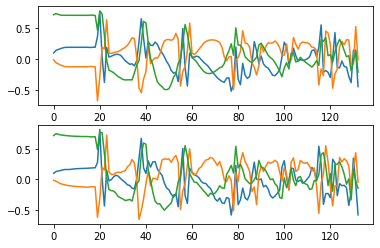

In [ ]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(predicted_latent[4, :3, :steps_to_predict].T)
true_latent_interval = true_latent[4, :3, :steps_to_predict*6:6]
ax[1].plot(true_latent_interval.T)

In [ ]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent, 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)

In [ ]:
# Loading in the original dataset for comparison
grids = np.load("/content/drive/MyDrive/Colab Notebooks/data/processed/sf_snapshots_800timesteps_notrand.npy")

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [ ]:
# Reshaping
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
predicted_grids_reshaped = predicted_grids.numpy().reshape((int(predicted_grids.shape[0]/10), 10, predicted_grids.shape[1], predicted_grids.shape[2], predicted_grids.shape[3], predicted_grids.shape[4]))

In [ ]:
# Calculate MSE loss
print("MSE loss of the prediction: ", np.mean(tf.keras.losses.MSE(grids_reshaped[:steps_to_predict*6:6, 2:10], predicted_grids_reshaped[:, 2:10])))

MSE loss of the prediction:  0.0015966961


In [ ]:
# Save the output
np.save("predicted_grids", predicted_grids[800:1200])

#### Predicting beyond the original domain size

In [ ]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 400))
boundaries[0] = train_data[2, :, 400:]
boundaries[1] = train_data[9, :, 400:]

init_values = np.zeros((96, 10))
init_values[:] = np.repeat(train_data[3:9, :, 400], 16, axis=0)

In [ ]:
steps_to_predict = 60 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, iters=3, sor=1, pre_interval=False, timestep_print_interval=4)

At timestep number  0
At timestep number  4
At timestep number  8
At timestep number  12
At timestep number  16
At timestep number  20
At timestep number  24
At timestep number  28
At timestep number  32
At timestep number  36
At timestep number  40
At timestep number  44
At timestep number  48
At timestep number  52
At timestep number  56


In [ ]:
# do the inverse transforms
predicted_latent = scaler.inverse_transform(
  predicted_latent.reshape(-1, 1)).reshape(predicted_latent.shape)

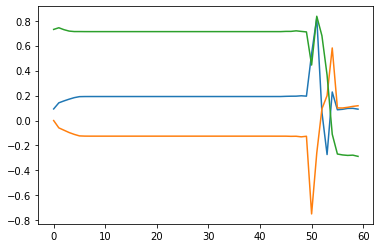

In [ ]:
plt.plot(predicted_latent[11, :3, :steps_to_predict].T)

It appears not much is happening in the rest of the domains as by the end of the simulation the slugs have not even reached very far. We need to predict beyond the original number of timesteps as well if we want to see interesting stuff happening.

In [ ]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent, 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)

In [ ]:
# Save the output
np.save("predicted_grids", predicted_grids)

#### Predicting beyond the original number of timesteps

This is more complex, since now we need to define some reasonable boundary conditions. We generate these boundaries by taking some subdomains from the original grid and generating various different types of noise around them

Before we generate these predictions let's look at some statistics for how often slugs form in the original simulation

In [8]:
# Loading in the original dataset for collecting statistics
grids = np.load("/content/drive/MyDrive/Colab Notebooks/data/processed/sf_snapshots_1705steps_notrand.npy")

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))

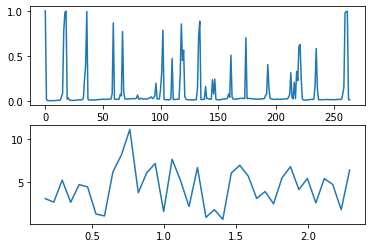

In [9]:
# Making a "sensor", essentially just extracting mass fraction component at
# central points in the subdomains
sensor = grids_reshaped[::6, :, 30, 10, :, 3]

sensor_position = sensor[20:, 4, 13]

# Pipe starts out full of air, which explains the flat line at 1 in the 
# beginning

# DFT to go to frequency domain
sample_rate = 100
time = 17.05

# Number of samples in normalized_tone
N = int(sample_rate * time)

xf = fftfreq(N, 1 / sample_rate)
yf = fft(sensor_position)

# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(sensor_position)
ax[1].plot(xf[3:40], np.abs(yf)[3:40])

Seems that the major peak corresponds to about 0.75 Hz

##### Boundary where we cycle around the creation of a slug

In [10]:
# This is for predicting further into the future with a changing boundary, 
# repeating an earlier value
boundaries = np.zeros((2, 10, 494))
boundaries[0, :, :134] = train_data[2, :, ::6]
boundaries[1, :, :134] = train_data[9, :, ::6]

# Here we pick a particular inlet, this one is one with steady flow (half blue,
# half red). Produces a steady state in the subsequent domains
boundaries[1, :, 134:] = np.repeat(boundaries[1:2, :, :][:, :, 125:126], 360, axis=2)
boundaries[0, :, 134:] = np.tile(np.concatenate((boundaries[0, :, 125:134], boundaries[0, :, 125:126]), axis=-1), (1,1,36))

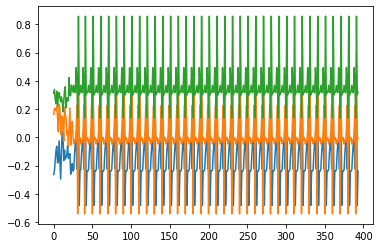

In [11]:
# What do the latent variables look like at the boundary
plt.plot(boundaries[0, :3, 100:].T)

In [12]:
# Let's now select a point to start which is a bit further along in time
start_t = 100
boundaries = boundaries[:, :, start_t:]

init_values = np.zeros((96, 10))
init_values[:] = np.repeat(train_data[3:9, :, start_t], 16, axis=0)

In [13]:
boundaries.shape

(2, 10, 394)

In [ ]:
steps_to_predict = 370 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, iters=3, sor=1, pre_interval=True, timestep_print_interval=100)

At timestep number  0


In [ ]:
np.save("latent_1.npy", predicted_latent)

In [ ]:
!mv ./latent_* "/content/drive/MyDrive/Colab Notebooks"

In [ ]:
plt.plot(predicted_latent[4, :3, :steps_to_predict].T)

In [ ]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent[0:10, :, :steps_to_predict], 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)
predicted_grids_reshaped = predicted_grids.numpy().reshape((int(predicted_grids.shape[0]/10), 10, predicted_grids.shape[1], predicted_grids.shape[2], predicted_grids.shape[3], predicted_grids.shape[4]))

In [ ]:
# Pipe starts out full of air, which explains the flat line at 1 in the 
# beginning
# Making a sensor
sensor = predicted_grids_reshaped[:, :, 30, 10, :, 3]

sensor_position = sensor[10:, 8, 11]

# DFT to go to frequency domain
sample_rate = 100
time = 17.05

# Number of samples in normalized_tone
N = int(sample_rate * time)

xf = fftfreq(N, 1 / sample_rate)
yf = fft(sensor_position)

# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(sensor_position)
ax[1].plot(xf[6:30], np.abs(yf)[6:30])

In [ ]:
np.save("predicted_grids_1.npy", predicted_grids)

In [ ]:
!mv ./predicted_* "/content/drive/MyDrive/Colab Notebooks"

##### Boundary where we add noise to an instability

In [ ]:
instability = grids_reshaped[133*6, 2:3]

# Generate n noisy timesteps
noisy_len = 360
noisy_instability = np.zeros((noisy_len, 60, 20, 20, 4))
for i in range(noisy_len):
  noisy_instability[i, :, :, :, :3] =  instability[:, :, :, :, :3]
  noisy_instability[i, :, :, :, 3] = instability[0, :, :, :, 3] + np.random.normal(scale = 0.45, size=(60, 20, 20))

In [ ]:
latent_vars = compressive_encoder.predict(noisy_instability)

In [ ]:
latent_vars = np.swapaxes(latent_vars, 0, 1);

In [ ]:
boundaries = np.zeros((2, 10, 14 + noisy_len))
boundaries[0, :, :14] = train_data[2, :, ::6][:, 120:]
boundaries[1, :, :14] = train_data[9, :, ::6][:, 120:]

# Here we pick a particular inlet, this one is one with steady flow (half blue,
# half red). Produces a steady state in the subsequent domains
boundaries[1, :, 14:] = np.repeat(boundaries[1:2, :, :][:, :, 125:126], noisy_len, axis=2)
boundaries[0, :, 14:] = latent_vars[:, ::1][:, :noisy_len]

init_values = np.zeros((24, 10))
init_values[:] = np.repeat(train_data[3:9, :, 120], 4, axis=0)

In [ ]:
plt.plot(boundaries[0].T)

In [ ]:
steps_to_predict = 350 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, iters=3, sor=1, pre_interval=True, timestep_print_interval=10)

In [ ]:
np.save("latent_2.npy", predicted_latent)

In [ ]:
!mv ./latent_* "/content/drive/MyDrive/Colab Notebooks"

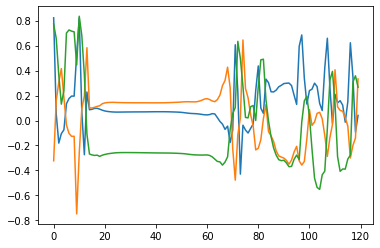

In [ ]:
+52plt.plot(predicted_latent[7, :3, :steps_to_predict].T)

In [ ]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent[0:10, :, :steps_to_predict], 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)
predicted_grids_reshaped = predicted_grids.numpy().reshape((int(predicted_grids.shape[0]/10), 10, predicted_grids.shape[1], predicted_grids.shape[2], predicted_grids.shape[3], predicted_grids.shape[4]))

NameError: ignored

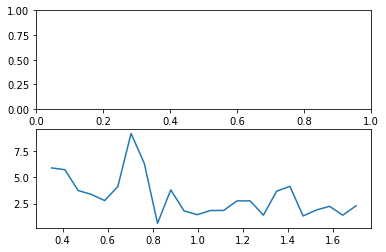

In [ ]:
# Pipe starts out full of air, which explains the flat line at 1 in the 
# beginning
# Making a sensor
sensor = predicted_grids_reshaped[:, :, 30, 10, :, 3]

sensor_position = sensor[15:, 9, 14]

# DFT to go to frequency domain
sample_rate = 100
time = 17.05

# Number of samples in normalized_tone
N = int(sample_rate * time)

xf = fftfreq(N, 1 / sample_rate)
yf = fft(sensor_position)

# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(sensor_position)
ax[1].plot(xf[6:30], np.abs(yf)[6:30])

In [ ]:
np.save("predicted_grids.npy", predicted_grids[600:1000])

##### Boundary where we add a random walk around the unperturbed state

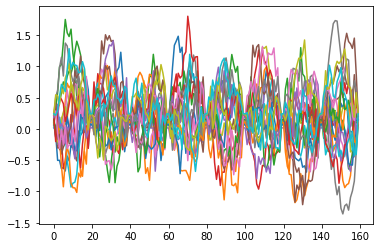

In [ ]:
# Function for a Brownian bridge, 
# from https://gist.github.com/delta2323/6bb572d9473f3b523e6e
in_shape = (60, 20, 20)
N = 20
n_iters = 8
len_tot = N*n_iters

def sample_path_batch_shape(N, in_shape, dt_factor=0.97):
    dt = 1.0 / (N -1)           
    dt_sqrt = np.sqrt(dt)
    B = np.empty((N,) + in_shape, dtype=np.float32)
    B[0, :, :, :] = 0
    for n in six.moves.range(N - 2):                
         t = n * dt
         xi = np.random.randn(*in_shape) * dt_sqrt * dt_factor
         B[n + 1] = B[n] * (1 - dt / (1 - t)) + xi
    B[-1] = 0                                                 
    return B

B_multiple = np.zeros((len_tot, 60, 20, 20, 4))
for i in range(n_iters):
  B_multiple[i*N:(i+1)*N, :, :, :, 3] = sample_path_batch_shape(N, in_shape)

B_multiple[:, :, :, :, 3] += np.repeat(np.expand_dims(grids_reshaped[750, 9, :, :, :, 3], 0), len_tot, axis=0)
B_multiple[:, :, :, :, :3] = grids_reshaped[750, 9, :, :, :, :3]

plt.plot(B_multiple[:, 10, :, 10, 3])
plt.show()

In [ ]:
latent_vars = compressive_encoder(B_multiple)

In [ ]:
boundaries = np.zeros((2, 10, 14 + len_tot))
boundaries[0, :, :14] = train_data[2, :, ::6][:, 120:]
boundaries[1, :, :14] = train_data[9, :, ::6][:, 120:]

# Here we pick a particular inlet, this one is one with steady flow (half blue,
# half red). Produces a steady state in the subsequent domains
boundaries[1, :, 14:] = np.repeat(train_data[1:2, :, ::6][:, :, 125:126], len_tot, axis=2)
boundaries[0, :, 14:] = latent_vars[:, ::1][:, :len_tot].numpy().T

init_values = np.zeros((24, 10))
init_values[:] = np.repeat(train_data[3:9, :, 120], 4, axis=0)

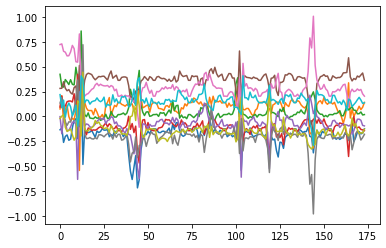

In [ ]:
plt.plot(boundaries[0].T)

In [ ]:
steps_to_predict = 80 # Predict n timesteps
predicted_latent = pred_adv.predict(boundaries, init_values, steps_to_predict, iters=3, sor=1, pre_interval=True, timestep_print_interval=10)

At timestep number  0
At timestep number  10
At timestep number  20
At timestep number  30
At timestep number  40
At timestep number  50
At timestep number  60
At timestep number  70


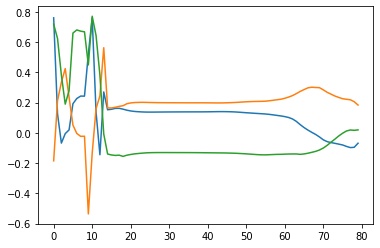

In [ ]:
plt.plot(predicted_latent[7, :3, :steps_to_predict].T)

In [ ]:
# Decompressing predicted grids
latent_reshaped = np.moveaxis(predicted_latent[0:10, :, :steps_to_predict], 2, 0).reshape(steps_to_predict*10, 10)
predicted_grids = compressive_decoder(latent_reshaped)
predicted_grids_reshaped = predicted_grids.numpy().reshape((int(predicted_grids.shape[0]/10), 10, predicted_grids.shape[1], predicted_grids.shape[2], predicted_grids.shape[3], predicted_grids.shape[4]))

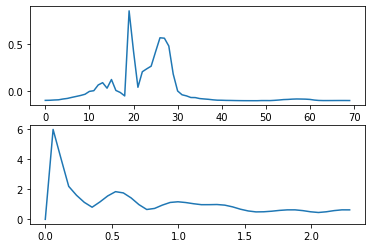

In [ ]:
# Pipe starts out full of air, which explains the flat line at 1 in the 
# beginning
# Making a sensor
sensor = predicted_grids_reshaped[:, :, 30, 10, :, 3]

sensor_position = sensor[10:, 2, 9] - np.mean(sensor[10:, 2, 9])

# DFT to go to frequency domain
sample_rate = 100
time = 17.05

# Number of samples in normalized_tone
N = int(sample_rate * time)

xf = fftfreq(N, 1 / sample_rate)
yf = fft(sensor_position)

# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(2,1)
ax[0].plot(sensor_position)
ax[1].plot(xf[0:40], np.abs(yf)[0:40])

In [ ]:
np.save("predicted_grids.npy", predicted_grids[600:1000])

In [ ]:
predicted_grids_reshaped[:, :, :, :, :, 3].shape

(120, 10, 60, 20, 20)

In [ ]:
predicted_grids_reshaped[:, :, 30, 10, :, 3].shape

(120, 10, 20)